# XGBoost Tuning (Descriptors + Fingerprints)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem, RDLogger
from rdkit.Chem import Descriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.ML.Descriptors import MoleculeDescriptors as md
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    cross_val_score,
    cross_validate,
    RandomizedSearchCV
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix
)
import xgboost as xgb
from xgboost import XGBClassifier
import shap
import optuna
from mordred import Calculator, descriptors as mordred_descriptors

/home/notebook/Documents/Workspace/Python/TP-Jupyter/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Molecule, Descriptor + Fingerprints and Outlier Functions

In [2]:
# Create calculator once
MORDRED_CALC = Calculator(mordred_descriptors, ignore_3D=True)

def molecule_from_smiles(smiles):
    lg = RDLogger.logger()
    # Temporarily silence RDKit logs (Only critical)
    lg.setLevel(RDLogger.CRITICAL)
    try:
        # Extract molecule
        molecule = Chem.MolFromSmiles(smiles, sanitize=True)
        if molecule is None:
            return None, "failed"

        # Remove salts
        clean_molecule = rdMolStandardize.LargestFragmentChooser()
        molecule = clean_molecule.choose(molecule)

        # Sanitize molecule again to reflect changes
        Chem.SanitizeMol(molecule)
        return molecule, "succeed"
    except Exception as e:
        return None, f"error: {e}"
    finally:
        # re-enable logging afterward
        lg.setLevel(RDLogger.INFO)


def calculate_descriptors(molecule):
    try:
        # Mordred returns a object
        result = MORDRED_CALC(molecule)

        # Convert to plain dict with string names as keys
        desc_dict = {}
        for name, value in result.items():
            key = str(name)

            # Mordred may return special error/None objects
            if value is None:
                desc_dict[key] = np.nan
                continue

            # Some values are not numeric - keep onlz numeric
            try:
                desc_dict[key] = float(value)
            except Exception:
                desc_dict[key] = np.nan

        return desc_dict

    except Exception as e:
        print(f"Mordred descriptor calc failed: {e}")
        return {}
    

def compute_iqr_limits(df, factor=1.5):
    # Calculate IQR limits
    limits = {}
    for col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        # If IQR is 0 - column is too flat - skip
        if iqr == 0 or np.isnan(iqr):
            continue

        lower = q1 - factor * iqr
        upper = q3 + factor * iqr
        limits[col] = (lower, upper)
    return limits


def apply_iqr_limits(df, limits):
    # Apply the limits
    df_clipped = df.copy()
    for col, (lower, upper) in limits.items():
        df_clipped[col] = df_clipped[col].clip(lower, upper)
    return df_clipped

## Dataset Processing

In [3]:
# Configuration
ORIG_DATASET = "in_chemico_dataset.xlsx"
SKIP_ROWS = 1
SMILES_COL = "SMILES code"
TARGET_COL = "Phototoxicity"
FULL_OUTPUT_DATASET = "in_chemico_dataset_processed.xlsx"

# Outputs
TRAIN_X_CSV = "in_chemico_x_train.csv"
TEST_X_CSV = "in_chemico_x_test.csv"
TRAIN_Y_CSV = "in_chemico_y_train.csv"
TEST_Y_CSV = "in_chemico_y_test.csv"

# Near constant threshold - tolerance
SIMILARITY_THRESHOLD = 0.90
# Correlation threshold
CORRELATION_THRESHOLD = 0.95

# Load dataset and skip first row (Header)
dataset = pd.read_excel(ORIG_DATASET, engine="openpyxl", skiprows=SKIP_ROWS)

# Build descriptors
descriptor_rows = []
state_molecules = []
molecules = []

# Loop over the SMILES column
for smiles in dataset[SMILES_COL].astype(str):
    molecule, state = molecule_from_smiles(smiles)
    state_molecules.append(state)
    molecules.append(molecule)

    # If molecule construction failed - empty placeholder
    if molecule is None:
        descriptor_rows.append({})
        continue
    # Calculate descriptors for each molecule
    descriptor_rows.append(calculate_descriptors(molecule))

# Convert list of dictionaries into dataframe
descriptor_data_all = pd.DataFrame(descriptor_rows)

# Keep everything + status
output = pd.concat(
    [dataset.reset_index(drop=True), descriptor_data_all.reset_index(drop=True)],
    axis=1
)
output["MoleculeStatus"] = state_molecules

# Output whole dataset with descriptors and state
with pd.ExcelWriter(FULL_OUTPUT_DATASET, engine="openpyxl") as writer:
    output.to_excel(writer, index=False, sheet_name="Descriptors")

print(f"Full - Rows: {len(output)}/Columns: {output.shape[1]}")
print(output.head().to_string(index=False))

# Drop failed molecules - boolean array
molecules_right = []
for molecule in molecules:
    if molecule is not None:
        molecules_right.append(True)
    else:
        molecules_right.append(False)
if not any(molecules_right):
    raise ValueError("No valid molecules after SMILES parsing.")

dataset_ok = dataset.loc[molecules_right].reset_index(drop=True)
descriptor_ok = descriptor_data_all.loc[molecules_right].reset_index(drop=True)

# Target
y_full = dataset_ok[TARGET_COL].astype(int)

# Take only numeric descriptor columns
X_full = descriptor_ok.select_dtypes(include=[np.number]).copy()
for column in X_full.columns:
    X_full[column] = X_full[column].replace([np.inf, -np.inf], np.nan)

# Drop columns that are entirely NaN
all_nan_cols = X_full.columns[X_full.isna().all()].tolist()
if all_nan_cols:
    print(f"Dropping {len(all_nan_cols)} NaN columns.")
    X_full = X_full.drop(columns=all_nan_cols)

# Split dataset - train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# Calculate medians for each column in train only
train_medians = X_train.median(numeric_only=True)

# Fill missing values in both train and test using those medians
X_train = X_train.fillna(train_medians)
X_test = X_test.fillna(train_medians)

# Compute constants on train only
constant_cols = []
for col in X_train.columns:
    top_freq = X_train[col].value_counts(normalize=True, dropna=False).max()
    if top_freq >= SIMILARITY_THRESHOLD:
        constant_cols.append(col)

# Drop from train and apply same drop to test
if constant_cols:
    X_train = X_train.drop(columns=constant_cols)
    X_test = X_test.drop(columns=constant_cols)
    print(f"Dropped {len(constant_cols)} constant/almost-constant columns.")

# Compute absolute correlation matrix on training data
corr_matrix = X_train.corr().abs()
# Keep only upper triangle of the matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find columns to drop - correlation
high_corr_cols = []
for col in upper.columns:
    if any(upper[col] > CORRELATION_THRESHOLD):
        high_corr_cols.append(col)

# Drop from both train and test
if high_corr_cols:
    X_train = X_train.drop(columns=high_corr_cols)
    X_test = X_test.drop(columns=high_corr_cols)
    print(f"Dropped {len(high_corr_cols)} highly correlated columns.")

# Compute IQR limits on training data
iqr_limits = compute_iqr_limits(X_train, factor=1.5)

# Apply limits to both train and test sets
X_train = apply_iqr_limits(X_train, iqr_limits)
X_test = apply_iqr_limits(X_test, iqr_limits)

X_train = pd.DataFrame(X_train, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test, columns=X_test.columns, index=X_test.index)

X_train.to_csv(TRAIN_X_CSV, index=False)
X_test.to_csv(TEST_X_CSV, index=False)
y_train.to_csv(TRAIN_Y_CSV, index=False, header=[TARGET_COL])
y_test.to_csv(TEST_Y_CSV, index=False, header=[TARGET_COL])

print(f"Train - Rows: {len(X_train)}/Columns: {X_train.shape[1]}")
print("First rows of train x:")
print(X_train.head().to_string(index=False))
print(f"Test - Rows: {len(X_test)}/Columns: {X_test.shape[1]}")
print("First rows of train y:")
print(y_train.head().to_string(index=False))
X_train.describe()

print("\nTrain set class counts:")
print(y_train.value_counts())
print("\nTrain set class ratio:")
print(y_train.value_counts(normalize=True))

print("\nTest set class counts:")
print(y_test.value_counts())
print("\nTest set class ratio:")
print(y_test.value_counts(normalize=True))

Full - Rows: 162/Columns: 1626
                          Name                                                                                              IUPAC name CAS registry number    Structure  Phototoxicity                                                      SMILES code                            Sources               Note    Unnamed: 8 Unnamed: 9  Unnamed: 10 Unnamed: 11  ABC  ABCGG  nAcid  nBase   SpAbs_A  SpMax_A  SpDiam_A    SpAD_A  SpMAD_A  LogEE_A    VE1_A    VE2_A    VE3_A      VR1_A    VR2_A    VR3_A  nAromAtom  nAromBond  nAtom  nHeavyAtom  nSpiro  nBridgehead  nHetero   nH  nB   nC  nN  nO  nS  nP  nF  nCl  nBr  nI  nX     ATS0dv  ATS1dv     ATS2dv     ATS3dv  ATS4dv  ATS5dv  ATS6dv  ATS7dv  ATS8dv  ATS0d  ATS1d  ATS2d  ATS3d  ATS4d  ATS5d  ATS6d  ATS7d  ATS8d      ATS0s      ATS1s      ATS2s      ATS3s      ATS4s      ATS5s      ATS6s      ATS7s      ATS8s  ATS0Z  ATS1Z  ATS2Z  ATS3Z  ATS4Z  ATS5Z  ATS6Z  ATS7Z  ATS8Z       ATS0m       ATS1m       ATS2m       ATS3m  

## Base Model Train

In [4]:
base_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42
)
# Train
base_model.fit(X_train, y_train)

# Predict
y_pred = base_model.predict(X_test)
y_prob = base_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nModel performance:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))


Model performance:
Accuracy:  0.7576
Precision: 0.8571
Recall:    0.6667
F1 score:  0.7500
ROC AUC:   0.8037

Classification report:
              precision    recall  f1-score   support

           0      0.684     0.867     0.765        15
           1      0.857     0.667     0.750        18

    accuracy                          0.758        33
   macro avg      0.771     0.767     0.757        33
weighted avg      0.779     0.758     0.757        33



## Feature Selection

PermutationExplainer explainer: 130it [01:57,  1.06it/s]                         
/tmp/ipykernel_66950/582230141.py:38: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train)


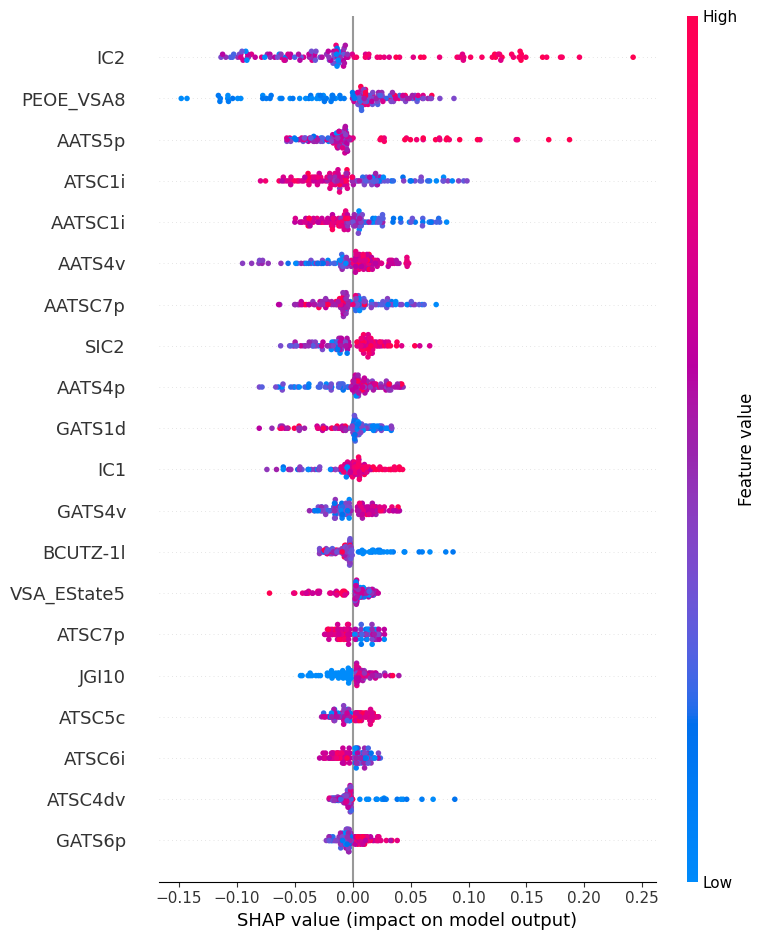

In [5]:
# SHAP features
# Prediction function for SHAP
f = lambda X: base_model.predict_proba(X)[:, 1]

explainer = shap.Explainer(f, X_train)
shap_result = explainer(X_train, max_evals=2 * X_train.shape[1] + 20)

# Each row has values for features
shap_values = shap_result.values

# Mean absolute SHAP value per feature (importance)
shap_importance = np.abs(shap_values).mean(axis=0)
shap_features = pd.Series(shap_importance, index=X_train.columns).sort_values(ascending=False)

# XGBoost features
xgb_importance = pd.Series(base_model.feature_importances_, index=X_train.columns)
xgb_features = xgb_importance.sort_values(ascending=False)

# K-Best - Anova features
kbest = SelectKBest(score_func=f_classif, k='all')
kbest.fit(X_train, y_train)
kbest_scores = pd.Series(kbest.scores_, index=X_train.columns).fillna(0.0)
kbest_features = kbest_scores.sort_values(ascending=False)

# Lasso features
lasso = LogisticRegression(
    penalty='l1',
    C=1.0,
    solver='liblinear',
    max_iter=5000
)
lasso.fit(X_train, y_train)

lasso_importance = pd.Series(np.abs(lasso.coef_).ravel(), index=X_train.columns)
lasso_features = lasso_importance.sort_values(ascending=False)

# Plot
shap.summary_plot(shap_values, X_train)

## SHAP Features

In [6]:
shap_features.head(20)

IC2            0.063874
PEOE_VSA8      0.036971
AATS5p         0.031172
ATSC1i         0.030031
AATSC1i        0.022595
AATS4v         0.021925
AATSC7p        0.021272
SIC2           0.020460
AATS4p         0.020140
GATS1d         0.016651
IC1            0.015711
GATS4v         0.015590
BCUTZ-1l       0.014301
VSA_EState5    0.012602
ATSC7p         0.012319
JGI10          0.012164
ATSC5c         0.010860
ATSC6i         0.010552
ATSC4dv        0.010096
GATS6p         0.009769
dtype: float64


CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.666707  0.694970    0.750371
1     10     0.728606  0.732867    0.797017
2     15     0.744111  0.751922    0.808424
3     20     0.744231  0.755599    0.786050
4     25     0.720433  0.730392    0.788417

Best number of features by CV F1: 20
Top_N          20.000000
CV_Accuracy     0.744231
CV_F1           0.755599
CV_ROC_AUC      0.786050
Name: 3, dtype: float64


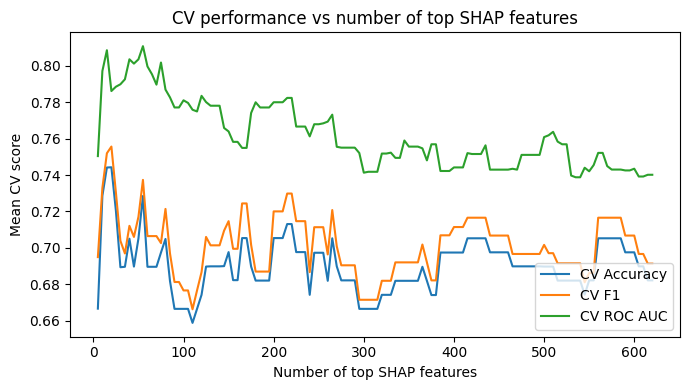

In [7]:
results = []

kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(shap_features) + 1, 5):
    top_feats = shap_features.head(n).index

    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric=["logloss", "auc"],
        random_state=42
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={
            "accuracy": "accuracy",
            "f1": "f1",
            "roc_auc": "roc_auc"
        },
        n_jobs=-1,
        return_train_score=False
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_shap = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top SHAP features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top SHAP features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## XGB Features

In [8]:
xgb_features.head(20)

IC2          0.071185
ATSC8d       0.056703
AATS4p       0.043068
PEOE_VSA8    0.037932
AATSC5p      0.036344
ATSC4dv      0.034220
ATSC3i       0.030340
GATS1d       0.028718
SpMAD_A      0.027063
AATSC8d      0.024670
SIC3         0.023348
TSRW10       0.020657
AATSC4se     0.020631
GATS7v       0.020478
AATS5p       0.020198
MINdssC      0.018224
AMID_O       0.017475
AATS4v       0.016130
ATSC7v       0.016123
AATSC6se     0.015523
dtype: float32


CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.720553  0.740172    0.777514
1     10     0.713101  0.737626    0.778585
2     15     0.720553  0.732441    0.773095
3     20     0.681851  0.700980    0.735665
4     25     0.736298  0.742396    0.753004

Best number of features by CV F1: 25
Top_N          25.000000
CV_Accuracy     0.736298
CV_F1           0.742396
CV_ROC_AUC      0.753004
Name: 4, dtype: float64


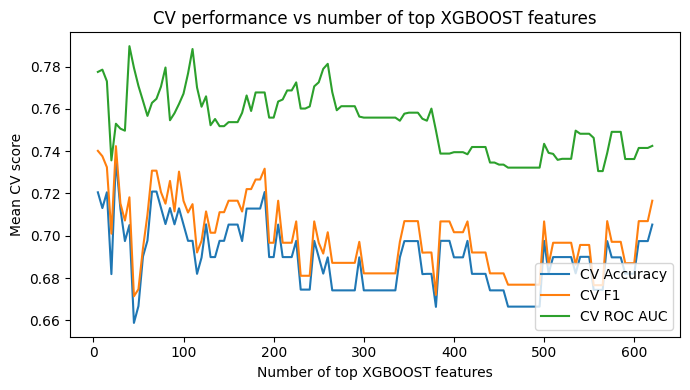

In [9]:
results = []

kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(xgb_features) + 1, 5):
    top_feats = xgb_features.head(n).index

    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric=["logloss", "auc"],
        random_state=42
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={
            "accuracy": "accuracy",
            "f1": "f1",
            "roc_auc": "roc_auc"
        },
        n_jobs=-1,
        return_train_score=False
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_xgb = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top XGBOOST features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top XGBOOST features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## KBEST Features

In [10]:
kbest_features.head(20)

piPC10           34.160643
GATS1d           30.525396
IC2              28.378547
AATS4d           28.338422
AXp-2d           27.935756
PEOE_VSA8        27.717288
BCUTZ-1l         27.436636
IC3              25.442869
nRing            24.977419
naHRing          24.069194
IC1              23.745728
n6Ring           22.674454
n6aRing          22.591072
nAromAtom        22.571429
SpMax_A          22.497991
SpAbs_A          22.254355
ETA_epsilon_3    22.119740
AATS3d           21.829762
fragCpx          21.341459
GATS2v           21.233975
dtype: float64


CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.651202  0.650794    0.714461
1     10     0.681731  0.694993    0.743964
2     15     0.666226  0.690269    0.737507
3     20     0.705048  0.723950    0.749664
4     25     0.674279  0.691176    0.741555

Best number of features by CV F1: 215
Top_N          215.000000
CV_Accuracy      0.720673
CV_F1            0.732143
CV_ROC_AUC       0.761583
Name: 42, dtype: float64


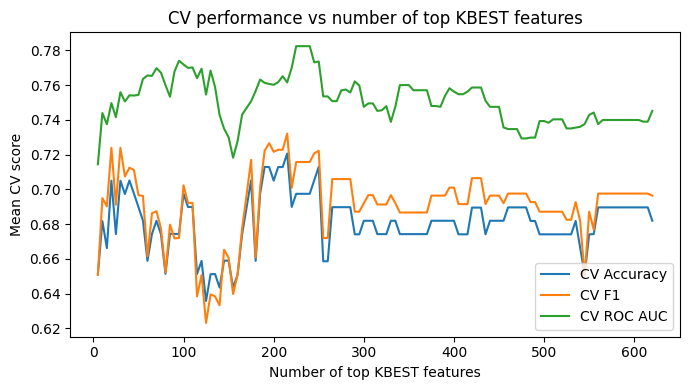

In [11]:
results = []

kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(kbest_features) + 1, 5):
    top_feats = kbest_features.head(n).index

    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric=["logloss", "auc"],
        random_state=42
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={
            "accuracy": "accuracy",
            "f1": "f1",
            "roc_auc": "roc_auc"
        },
        n_jobs=-1,
        return_train_score=False
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_kbest = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top KBEST features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top KBEST features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## LASSO Features

In [12]:
lasso_features.head(20)

SlogP_VSA10    0.414960
ZMIC1          0.303471
SMR_VSA7       0.291354
EState_VSA5    0.280042
SlogP_VSA6     0.275602
TSRW10         0.248925
ATSC5dv        0.225238
ATSC7s         0.199959
ATSC8s         0.187429
ATSC4s         0.140704
ATSC3s         0.139246
AATSC7v        0.125178
ATSC6dv        0.123750
AATSC8v        0.116097
AATS8v         0.115825
EState_VSA7    0.115051
ATSC3Z         0.104476
ATS0s          0.096221
EState_VSA8    0.095051
EState_VSA4    0.080267
dtype: float64


CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.589303  0.601312    0.645770
1     10     0.558173  0.577700    0.612591
2     15     0.589063  0.595382    0.630644
3     20     0.550240  0.560606    0.608796
4     25     0.589423  0.596082    0.616008

Best number of features by CV F1: 280
Top_N          280.000000
CV_Accuracy      0.744111
CV_F1            0.751922
CV_ROC_AUC       0.752507
Name: 55, dtype: float64


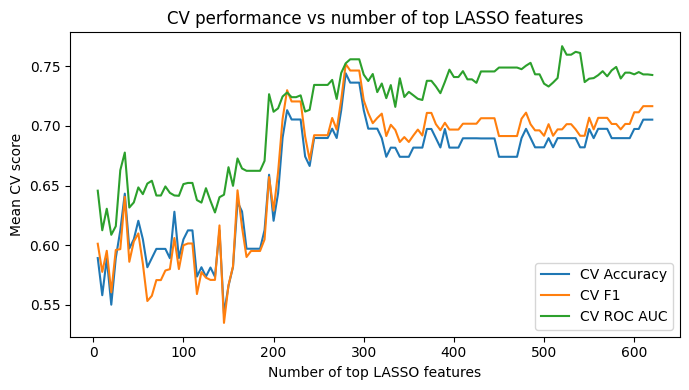

In [13]:
results = []

kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(lasso_features) + 1, 5):
    top_feats = lasso_features.head(n).index

    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric=["logloss", "auc"],
        random_state=42
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={
            "accuracy": "accuracy",
            "f1": "f1",
            "roc_auc": "roc_auc"
        },
        n_jobs=-1,
        return_train_score=False
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_lasso = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top LASSO features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top LASSO features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## Model SHAP Features

In [14]:
top_feats = shap_features.head(best_n_shap).index.tolist()

# Train final model
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (SHAP) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (SHAP) on test:
Accuracy:  0.6364
Precision: 0.6875
Recall:    0.6111
F1 score:  0.6471
ROC AUC:   0.7481


## Model XGB Features

In [15]:
top_feats = xgb_features.head(best_n_xgb).index.tolist()

# Train final model
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (XGB) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (XGB) on test:
Accuracy:  0.6970
Precision: 0.7500
Recall:    0.6667
F1 score:  0.7059
ROC AUC:   0.7593


## Model KBEST Features

In [16]:
top_feats = kbest_features.head(best_n_kbest).index.tolist()

# Train final model
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (KBEST) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (KBEST) on test:
Accuracy:  0.6970
Precision: 0.7500
Recall:    0.6667
F1 score:  0.7059
ROC AUC:   0.7444


## Model LASSO Features

In [17]:
top_feats = lasso_features.head(best_n_lasso).index.tolist()

# Train final model
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (LASSO) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (LASSO) on test:
Accuracy:  0.7273
Precision: 0.7647
Recall:    0.7222
F1 score:  0.7429
ROC AUC:   0.7481


## Model SHAP Features Tuning

In [18]:
top_feats = shap_features.head(best_n_shap).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)

# Optuna
def objective(trial):
    # Hyperparameter search space
    params = {
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "auc"],
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "max_depth": trial.suggest_int("max_depth", 4, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 0.7),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
        "gamma": trial.suggest_float("gamma", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),

    }

    model = xgb.XGBClassifier(**params)

    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        # scoring="f1",
        scoring="roc_auc",
        n_jobs=-1
    )

    return scores.mean()

# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

# Final model
best_params = study.best_params
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
    **best_params
)

final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (SHAP):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Best trial: 150. Best value: 0.840273: 100%|██████████| 200/200 [00:08<00:00, 24.73it/s]


Best trial:
  Value: 0.8402731092436975
  Params:
    n_estimators: 62
    max_depth: 7
    learning_rate: 0.05924302130967159
    subsample: 0.5003070322185839
    colsample_bytree: 0.5579308846427793
    min_child_weight: 2.668768230817169
    gamma: 1.6051627711155845
    reg_lambda: 0.09991408667619663
    reg_alpha: 0.03340559450346459

Final Optuna model (SHAP):
Accuracy:  0.6970
Precision: 0.7500
Recall:    0.6667
F1 score:  0.7059
ROC AUC:   0.7815


## Model XGB Features Tuning

In [19]:
top_feats = xgb_features.head(best_n_xgb).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)

# Optuna
def objective(trial):
    # Hyperparameter search space
    params = {
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "auc"],
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "max_depth": trial.suggest_int("max_depth", 4, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 0.7),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
        "gamma": trial.suggest_float("gamma", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
    }

    model = xgb.XGBClassifier(**params)

    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        # scoring="f1",
        scoring="roc_auc",
        n_jobs=-1
    )

    return scores.mean()

# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

# Final model
best_params = study.best_params
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
    **best_params
)

final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (XGB):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Best trial: 180. Best value: 0.831071: 100%|██████████| 200/200 [00:08<00:00, 24.45it/s]



Best trial:
  Value: 0.8310714285714286
  Params:
    n_estimators: 55
    max_depth: 6
    learning_rate: 0.19015361236052172
    subsample: 0.6371461811094031
    colsample_bytree: 0.5719273537837647
    min_child_weight: 1.288468946972744
    gamma: 1.9493296445426591
    reg_lambda: 0.01004515864961836
    reg_alpha: 1.1387710195212442

Final Optuna model (XGB):
Accuracy:  0.7879
Precision: 0.8667
Recall:    0.7222
F1 score:  0.7879
ROC AUC:   0.8000


## Model KBEST Features Tuning

In [20]:
top_feats = kbest_features.head(best_n_kbest).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)

# Optuna
def objective(trial):
    # Hyperparameter search space
    params = {
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "auc"],
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "max_depth": trial.suggest_int("max_depth", 4, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 0.7),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
        "gamma": trial.suggest_float("gamma", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
    }

    model = xgb.XGBClassifier(**params)

    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        # scoring="f1",
        scoring="roc_auc",
        n_jobs=-1
    )

    return scores.mean()

# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

# Final model
best_params = study.best_params
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
    **best_params
)

final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (KBEST):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Best trial: 77. Best value: 0.79556: 100%|██████████| 200/200 [00:24<00:00,  8.33it/s]



Best trial:
  Value: 0.7955602240896358
  Params:
    n_estimators: 111
    max_depth: 4
    learning_rate: 0.08493218216215678
    subsample: 0.5393110214275387
    colsample_bytree: 0.531516009084635
    min_child_weight: 1.5184681927592187
    gamma: 1.8435835601533883
    reg_lambda: 0.010040197276597303
    reg_alpha: 0.13113622203836595

Final Optuna model (KBEST):
Accuracy:  0.6364
Precision: 0.6667
Recall:    0.6667
F1 score:  0.6667
ROC AUC:   0.7370


## Model LASSO Features Tuning

In [21]:
top_feats = lasso_features.head(best_n_lasso).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)

# Optuna
def objective(trial):
    # Hyperparameter search space
    params = {
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "auc"],
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "max_depth": trial.suggest_int("max_depth", 4, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 0.7),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
        "gamma": trial.suggest_float("gamma", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
    }

    model = xgb.XGBClassifier(**params)

    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        # scoring="f1",
        scoring="roc_auc",
        n_jobs=-1
    )

    return scores.mean()

# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

# Final model
best_params = study.best_params
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
    **best_params
)

final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (LASSO):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Best trial: 175. Best value: 0.769818: 100%|██████████| 200/200 [00:27<00:00,  7.26it/s]



Best trial:
  Value: 0.7698179271708683
  Params:
    n_estimators: 130
    max_depth: 5
    learning_rate: 0.08207002914790663
    subsample: 0.6966137568608927
    colsample_bytree: 0.5269477069492503
    min_child_weight: 3.2214281200830874
    gamma: 1.2924849504026985
    reg_lambda: 0.046878940414148265
    reg_alpha: 1.4791525405859487

Final Optuna model (LASSO):
Accuracy:  0.6061
Precision: 0.6471
Recall:    0.6111
F1 score:  0.6286
ROC AUC:   0.7370


## Model SHAP Features Tuning + Early Stopping

In [22]:
# Feature selection
top_feats = shap_features.head(best_n_shap).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)

# Optuna objective with CV + early stopping
def objective(trial):
    # Hyperparameter search space
    params = {
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "auc"],
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "max_depth": trial.suggest_int("max_depth", 4, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 0.7),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
        "gamma": trial.suggest_float("gamma", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
        "early_stopping_rounds": trial.suggest_int("early_stopping_rounds", 10, 40),
    }

    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

    fold_aucs = []

    for train_idx, valid_idx in cv.split(X_train_fs, y_train):
        X_tr, X_val = X_train_fs.iloc[train_idx], X_train_fs.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model = xgb.XGBClassifier(**params)

        model.fit(
            X_tr,
            y_tr,
            eval_set=[(X_val, y_val)],
            verbose=False
        )

        y_val_pred = model.predict_proba(X_val)[:, 1]
        fold_auc = roc_auc_score(y_val, y_val_pred)
        fold_aucs.append(fold_auc)

    return np.mean(fold_aucs)


# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

# Final model
best_params = study.best_params.copy()

# Extract early_stopping_rounds from tuned params
best_esr = best_params.pop("early_stopping_rounds", 30)

final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
    early_stopping_rounds=best_esr,
    **best_params
)

# Use an internal validation split for early stopping
X_tr_final, X_val_final, y_tr_final, y_val_final = train_test_split(
    X_train_fs, y_train, test_size=0.2, stratify=y_train, random_state=42
)

final_model.fit(
    X_tr_final,
    y_tr_final,
    eval_set=[(X_val_final, y_val_final)],
    verbose=False
)

# Evaluate on test set
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (LASSO + CV + Early Stopping):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

Best trial: 142. Best value: 0.854146: 100%|██████████| 200/200 [00:17<00:00, 11.27it/s]



Best trial:
  Value: 0.8541456582633054
  Params:
    n_estimators: 106
    max_depth: 5
    learning_rate: 0.1163788141348938
    subsample: 0.5334511796504466
    colsample_bytree: 0.5289625566716782
    min_child_weight: 3.118862493200802
    gamma: 1.1772507795360359
    reg_lambda: 0.13637211938104452
    reg_alpha: 0.16885282278382774
    early_stopping_rounds: 37

Final Optuna model (LASSO + CV + Early Stopping):
Accuracy:  0.6970
Precision: 0.7500
Recall:    0.6667
F1 score:  0.7059
ROC AUC:   0.7889


## Model SHAP Features Tuning (Randomized Search CV)


=== Testing top 5 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': 80, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Accuracy: 0.636 | ROC-AUC: 0.656

=== Testing top 6 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': 80, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Accuracy: 0.727 | ROC-AUC: 0.744

=== Testing top 7 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': 20, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Accuracy: 0.697 | ROC-AUC: 0.781

=== Testing top 8 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': 20, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Accuracy: 0.667 | ROC-AUC: 0.741

=== Testing top 9 features ===
Best parameters: {'subsample': 0.8, 'n_estimators': 20, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Accuracy: 0.727 | ROC-AUC: 0.804

=== Testing top 10 features ===
Best parameters: {'subsample': 1.0, 'n_esti

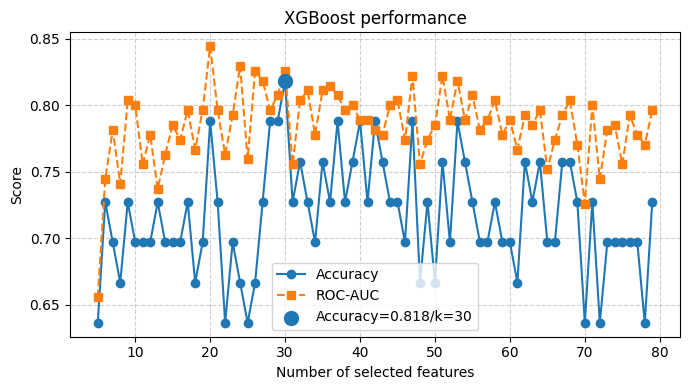


Accuracy = 0.818/ROC-AUC = 0.826/k = 30


In [23]:
ranking = shap_features

param_dist = {
    "n_estimators": np.arange(20, 160, 20),
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

results = []
for k in range(5, 80, 1):
    print(f"\n=== Testing top {k} features ===")

    # Select k values
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="roc_auc",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Choose best by accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5, label=f'Accuracy={best_acc:.3f}/k={best_k}')
plt.title('XGBoost performance')
plt.xlabel('Number of selected features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f}/ROC-AUC = {best_auc:.3f}/k = {best_k}")

## Model XGB Features Tuning (Randomized Search CV)


=== Testing top 5 features ===
Best parameters: {'subsample': 0.8, 'n_estimators': 20, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
Accuracy: 0.697 | ROC-AUC: 0.744

=== Testing top 6 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': 80, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Accuracy: 0.697 | ROC-AUC: 0.774

=== Testing top 7 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': 80, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Accuracy: 0.697 | ROC-AUC: 0.774

=== Testing top 8 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': 20, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Accuracy: 0.758 | ROC-AUC: 0.807

=== Testing top 9 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': 60, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Accuracy: 0.636 | ROC-AUC: 0.767

=== Testing top 10 features ===
Best parameters: {'subsample': 1.0, 'n_esti

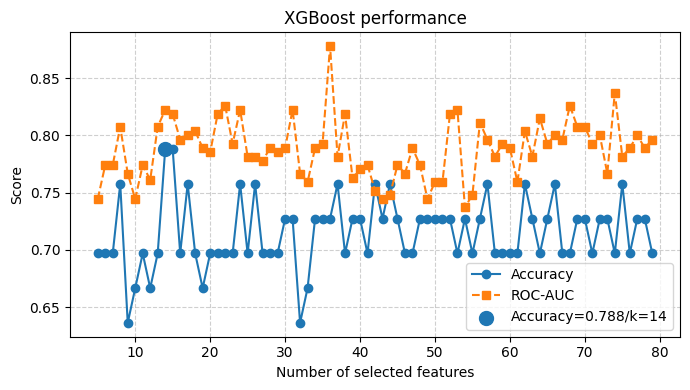


Accuracy = 0.788/ROC-AUC = 0.822/k = 14


In [24]:
ranking = xgb_features

param_dist = {
    "n_estimators": np.arange(20, 160, 20),
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

results = []
for k in range(5, 80, 1):
    print(f"\n=== Testing top {k} features ===")

    # Select k values
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=200,
        scoring="roc_auc",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Choose best by accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5, label=f'Accuracy={best_acc:.3f}/k={best_k}')
plt.title('XGBoost performance')
plt.xlabel('Number of selected features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f}/ROC-AUC = {best_auc:.3f}/k = {best_k}")

## Model KBEST Features Tuning (Randomized Search CV)


=== Testing top 5 features ===
Best parameters: {'subsample': 0.8, 'n_estimators': 20, 'max_depth': 5, 'learning_rate': 0.3, 'colsample_bytree': 0.8}
Accuracy: 0.727 | ROC-AUC: 0.830

=== Testing top 6 features ===
Best parameters: {'subsample': 0.8, 'n_estimators': 140, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Accuracy: 0.636 | ROC-AUC: 0.748

=== Testing top 7 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': 120, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Accuracy: 0.697 | ROC-AUC: 0.741

=== Testing top 8 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': 20, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Accuracy: 0.667 | ROC-AUC: 0.756

=== Testing top 9 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': 40, 'max_depth': 6, 'learning_rate': 0.3, 'colsample_bytree': 0.8}
Accuracy: 0.697 | ROC-AUC: 0.781

=== Testing top 10 features ===
Best parameters: {'subsample': 0.8, 'n_est

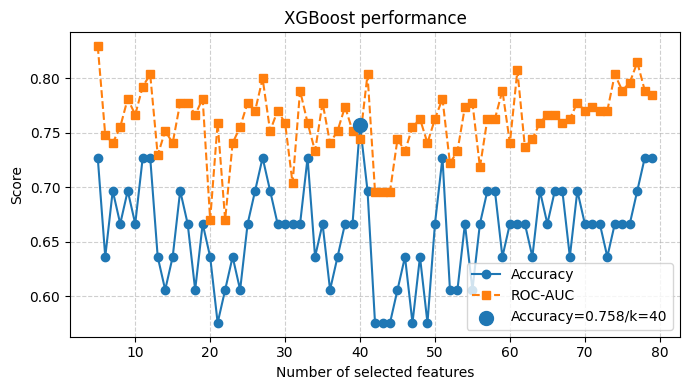


Accuracy = 0.758/ROC-AUC = 0.744/k = 40


In [25]:
ranking = kbest_features

param_dist = {
    "n_estimators": np.arange(20, 160, 20),
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

results = []
for k in range(5, 80, 1):
    print(f"\n=== Testing top {k} features ===")

    # Select k values
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="roc_auc",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Choose best by accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5, label=f'Accuracy={best_acc:.3f}/k={best_k}')
plt.title('XGBoost performance')
plt.xlabel('Number of selected features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f}/ROC-AUC = {best_auc:.3f}/k = {best_k}")

## Model LASSO Features Tuning (Randomized Search CV)


=== Testing top 5 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.3, 'colsample_bytree': 1.0}
Accuracy: 0.697 | ROC-AUC: 0.789

=== Testing top 6 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': 20, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Accuracy: 0.727 | ROC-AUC: 0.763

=== Testing top 7 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': 60, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Accuracy: 0.697 | ROC-AUC: 0.770

=== Testing top 8 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': 80, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
Accuracy: 0.818 | ROC-AUC: 0.859

=== Testing top 9 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': 20, 'max_depth': 6, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
Accuracy: 0.667 | ROC-AUC: 0.811

=== Testing top 10 features ===
Best parameters: {'subsample': 1.0, 'n_estim

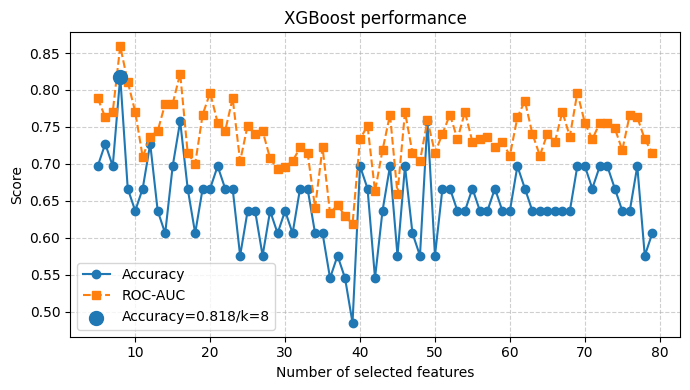


Accuracy = 0.818/ROC-AUC = 0.859/k = 8


In [26]:
ranking = lasso_features

param_dist = {
    "n_estimators": np.arange(20, 160, 20),
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

results = []
for k in range(5, 80, 1):
    print(f"\n=== Testing top {k} features ===")

    # Select k values
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="roc_auc",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Choose best by accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5, label=f'Accuracy={best_acc:.3f}/k={best_k}')
plt.title('XGBoost performance')
plt.xlabel('Number of selected features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f}/ROC-AUC = {best_auc:.3f}/k = {best_k}")